### Импорты

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix

In [2]:
def dict_sum(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        result[key] = result.get(key, 0) + value
    return result

### Класс представления сообщения

In [3]:
class Message:
    def __init__(self, filename):
        self._filename = filename
        self._subject_words = {}
        self._body_words = {}
        with open(filename) as f:
            subject = f.readline()[len("Subject: "):]
            for word in subject.split():
                self._subject_words[word] = self._subject_words.get(word, 0) + 1

            f.readline()

            body = f.read()
            for word in body.split():
                self._body_words[word] = self._body_words.get(word, 0) + 1

    def get_filename(self):
        return self._filename

    def get_subject(self):
        return self._subject_words.copy()

    def get_body(self):
        return self._body_words.copy()

    def vectorize(self, all_words, arg1="together", arg2="existing"):
        def get_value(x):
            if arg2 == "existing":
                return 1 if x > 0 else 0
            elif arg2 == "counting":
                return x

        if arg1 == "together":
            words = dict_sum(self.get_subject(), self.get_body())
            return [get_value(words.get(key, 0)) for key in all_words.keys()]
        elif arg1 == "separately":
            s_vect = {key: get_value(self.get_subject().get(key, 0)) for key in all_words.keys()}
            b_vect = {key: get_value(self.get_body().get(key, 0)) for key in all_words.keys()}
            s_vect.update(b_vect)
            return list(s_vect.values())

### Парсим тесты

In [4]:
messages = [Message("data/" + f) for f in listdir("data")]
all_subject_words, all_body_words = {}, {}
for message in messages:
    all_subject_words = dict_sum(all_subject_words, message.get_subject())
    all_body_words = dict_sum(all_body_words, message.get_body())
all_words = dict_sum(all_subject_words, all_body_words)

### Наивный байесовский классификатор

In [5]:
def split_on_test_and_train(arg1, arg2):
    X = np.array([np.array(msg.vectorize(all_words, arg1, arg2)) for msg in messages])
    Y = [msg.get_filename() for msg in messages]
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=0)
    train_X, test_X = csr_matrix(train_X), csr_matrix(test_X)
    return train_X, test_X, [int("legit" in name) for name in train_Y], [int("legit" in name) for name in test_Y]

In [6]:
args = [(arg1, arg2) for arg1 in ("together", "separately") for arg2 in ("existing", "counting")]

results = []
for arg1, arg2 in args:
    train_X, test_X, train_Y, test_Y = split_on_test_and_train(arg1, arg2)
    clf = MultinomialNB().fit(train_X, train_Y)
    predicted = clf.predict_proba(test_X)
    results.append([(arg1, arg2), (predicted, test_Y)])

### ROC кривая

In [20]:
def draw(name, predicted, test_Y):
    fpr, tpr, _ = metrics.roc_curve(test_Y, predicted[:, 1])
    auc = roc_auc_score(test_Y, predicted[:, 1])
    plt.title(f"{name}: auc={auc}")
    plt.plot(fpr, tpr, color="orange")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.show()

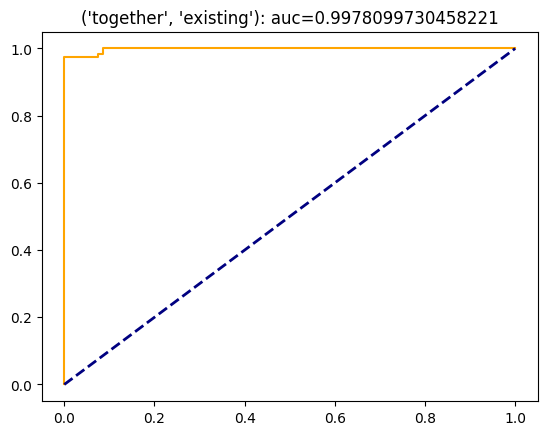

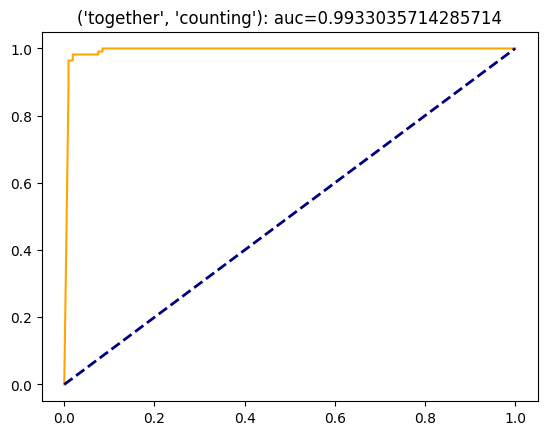

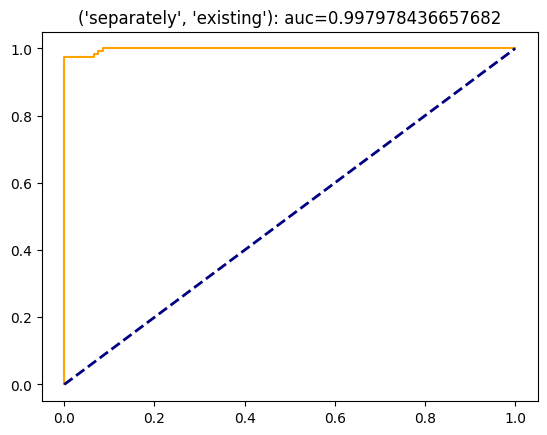

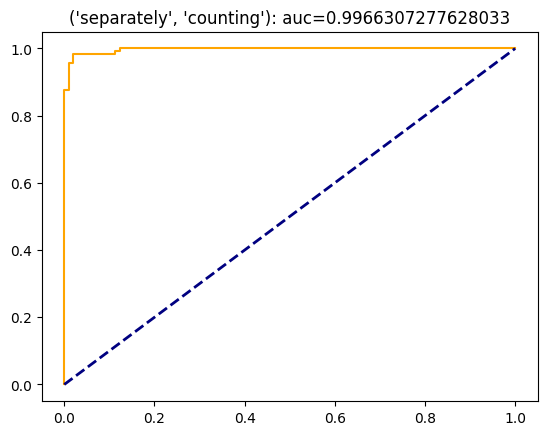

In [21]:
for result in results:
    draw(result[0], *result[1])

### Реализация "Без промахов"

In [48]:
train_X, test_X, train_Y, test_Y = split_on_test_and_train("separately", "existing")

In [49]:
no_error = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=[1e-15, 1]).fit(train_X, train_Y)
predicted = no_error.predict(test_X)
counter = 0
for i in range(len(test_Y)):
    if test_Y[i] and not predicted[i]:
        counter += 1
print("missed:", counter)

missed: 0


### График зависимости точности классификации от изменения априорного распределения в логарифмированном пространстве

In [56]:
def prior_f(x):
    with_prior = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=[x, 1]).fit(train_X, train_Y)
    predicted = with_prior.predict(test_X)
    return metrics.accuracy_score(test_Y, predicted)

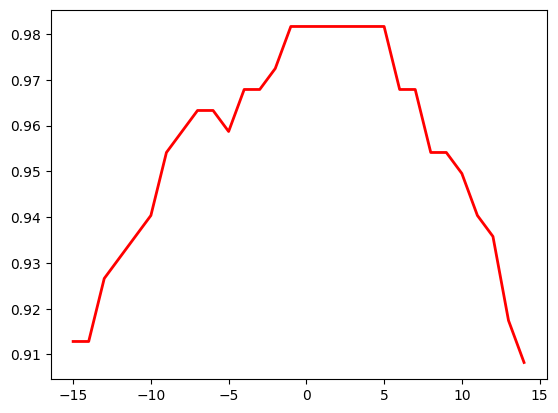

In [57]:
xs, ys = [*range(-15, 15)], [prior_f(10 ** x) for x in range(-15, 15)]
plt.plot(xs, ys, color="red", lw=2)
plt.show()